In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dis import dis
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

class CalNutritionTransformDistance(object):

    # def __init__(self, DataFile):
    #     self.

    def readData(self, file):
        """read the supply and demand data and preprocessing

        Args:
            file (string): file path

        Returns:
            DataFrame: pandas DF for further calculation
        """
        df = pd.read_csv(file)
        df = df.fillna(0)

        #计算需求值
        df['pneed'] = df['grid_code'] * 30

        #将供给与需求值合并
        df['gridResult'] = df['buildingP'] - df['pneed']
        return df

    def calEucDistance(self, value1, value2):
        """The Euculidian Distance between two grid

        Args:
            value1 (tuple): coordinates of grid1
            value2 (tuple): coordinates of grid2

        Returns:
            int: the distance between grid1 and grid2
        """
        return ((value1[0] - value2[0])**2 + (value1[1] - value2[1])**2)**0.5


    def showMatrix(self, value, name = r'C:\Users\oo\Desktop\Project-Nutrition-Distance\codes\test\test.jpg', shape=(100, 100)):
        """Visualize the Nutrition Supply and Demand situation

        Args:
            value (Array): supply - demand of all grids
            shape (tuple, optional): the grid resolution of research area. Defaults to (100, 100).
        """
        v = value.reshape(shape[0], shape[1])
        fixValues = np.zeros(shape)
        for i in range(shape[0]):
            fixValues[shape[0] - i - 1] = v[i]
        plt.imshow(fixValues, cmap='magma', norm=matplotlib.colors.Normalize(value.min(), value.max()))
        plt.savefig(name, dpi=300)


    def showGridNumbers(self, value):
        """Show the number of supply and demand grids respectively

        Args:
            value (Array): supply - demand of all grids
        """
        demandGridNumbers = (value < 0).sum()
        supplyGridNumbers = (value > 0).sum()
        supplyTotal = value[value > 0].sum()
        demandTotal = value[value < 0].sum()

        print("供给网格数量为{0}, 总量为{1}KG".format(supplyGridNumbers, supplyTotal))
        print("需求网格数量为{0}, 总量为{1}KG".format(demandGridNumbers, demandTotal))
        print("总网格数量为{}".format(value.shape[0] * value.shape[1]))
        return supplyGridNumbers, supplyTotal, demandGridNumbers, demandTotal, value.shape[0] * value.shape[1]


    def calcGridIndex(self, value, shape=(100, 100)):
        """计算供给与需求在网格矩阵中的索引

        Args:
            value (Array): supply - demand of all grids
            shape (tuple, optional): 网格分辨率. Defaults to (100, 100).

        Returns:
            list: 返回三个列表，第一个是二维矩阵，包含所有的供给量信息，第二和第三个分别是需求的索引
        """
        twoDArray = value.reshape(shape[0], shape[1])
        supplyIndex = []
        demandIndex = []
        for i in range(shape[0]):
            for j in range(shape[0]):
                if twoDArray[i][j] > 0:
                    supplyIndex.append((i,j))
                elif twoDArray[i][j] < 0:
                    demandIndex.append((i,j))
        return twoDArray, supplyIndex, demandIndex


    def calcIndexDistance(self, supplyIndex, demandIndex):
        """计算每个供给网格到所有需求网格的距离

        Args:
            supplyIndex (list): 所有供给网格的索引（即坐标）
            demandIndex (list): 所有需求网格的索引（即坐标）

        Returns:
            dict: 字典的键为供给索引号，值为一个二维列表，其中第一个值为需求索引，值为距离
        """
        s_to_d_distance = {}
        for s in supplyIndex:
            s_to_d_distance[s] = []
            for d in demandIndex:
                s_to_d_distance[s].append([d, self.calEucDistance(s, d)])
        return s_to_d_distance

    def sortDisDict(self, s_to_d_distance):
        """对距离字典进行排序

        Args:
            s_to_d_distance (dict): 各供给点至需求点距离

        Returns:
            dict: 排序后的距离字典
        """
        sortedDistanceDict = {}
        for i in s_to_d_distance:
            sortedDistanceDict[i] = sorted(s_to_d_distance[i], key=lambda x: x[1])
        return sortedDistanceDict


    def calcIndexWithValueSupply(self, twoDArray, sortedDistanceDict):
        """为每个供给点索引赋予供给值，并从大到小进行排列

        Args:
            twoDArray (list): 包括所有供需值的二维列表
            sortedDistanceDict (dict): 排序后的供需距离字典

        Returns:
            list: 从大到小排列的供给索引及攻击值
        """
        indexWithValueSupply = []
        for index in sortedDistanceDict.keys():
            supply = twoDArray[index]
            indexWithValueSupply.append([index, supply])
        indexWithValueSupply.sort(key=lambda x : x[1], reverse=True)
        return indexWithValueSupply
        

    

    def iterateCalculation(self, twoDArray, indexWithValueSupply, sortedDistanceDict, resPerGrid):
        """算法的主要实现步骤，计算与迭代

        Args:
            twoDArray ([type]): [description]
            indexWithValueSupply ([type]): [description]
            sortedDistanceDict ([type]): [description]

        Returns:
            [type]: [description]
        """
        transformMass = []
        transformDistance = []
        distance_array = []
        distancePerSupplyList = []
        massPerSupplyList = []
        supplyindex = 0
        testTwoDArray = twoDArray.copy()
        for supply in indexWithValueSupply:
            distancePerSupply = []
            massPerSupply = []
            tempSupply = testTwoDArray[supply[0]]
            for demand in sortedDistanceDict[supply[0]]:
                distancePerSupply.append(demand[1]* resPerGrid)
                tempDemand = testTwoDArray[demand[0]]

                if tempSupply <= -tempDemand:
                    massPerSupply.append(abs(tempSupply))
                    transformMass.append(abs(tempSupply))
                    tempDemand += tempSupply
                    tempSupply = 0
                    testTwoDArray[supply[0]] = tempSupply
                    testTwoDArray[demand[0]] = tempDemand

                    
                    transformDistance.append(demand[1]* resPerGrid)

                    
                elif tempSupply > tempDemand:
                    massPerSupply.append(abs(tempDemand))
                    transformMass.append(abs(tempDemand))
                    tempSupply += tempDemand
                    tempDemand = 0
                    testTwoDArray[supply[0]] = tempSupply
                    testTwoDArray[demand[0]] = tempDemand

                    
                    transformDistance.append(demand[1]* resPerGrid)
                else:
                    pass
                if tempSupply == 0:
                    distance_array.append([supply[0], demand[0], self.calEucDistance(supply[0], demand[0])* resPerGrid])
                    break
            distancePerSupplyList.append(distancePerSupply)
            massPerSupplyList.append(massPerSupply)
            supplyindex += 1
            # self.showMatrix(testTwoDArray, name = r'C:\Users\oo\Desktop\Project-Nutrition-Distance\codes\test\show{0}.jpg'.format(supplyindex), shape=(50, 50))
        distance_array.sort(key=lambda x: x[2], reverse=True)
        
        return distance_array, testTwoDArray, transformMass, transformDistance,distancePerSupplyList, massPerSupplyList


        


In [22]:
def calDisResult(fileTitle = 'initGrid', resoulution = 5):
    mwdis = 0
    resPerGrid = 100 / resoulution
    fileName = 'initGrid5'
    calObj = CalNutritionTransformDistance()
    df = calObj.readData('/Users/zowcool/Desktop/Projects/Project-Nutrition-Distance/DataWithoutSludge/{0}.csv'.format(fileTitle + str(resoulution)))
    twoDArray, supplyIndex, demandIndex = calObj.calcGridIndex(df['gridResult'].values, (int(df.shape[0]**0.5),int(df.shape[0]**0.5)))
    supplyGridNumbers, supplyTotal, demandGridNumbers, demandTotal, totalGrids = calObj.showGridNumbers(twoDArray)
    s_to_d_distance = calObj.calcIndexDistance(supplyIndex, demandIndex)
    sortedDistanceDict = calObj.sortDisDict(s_to_d_distance)
    indexWithValueSupply = calObj.calcIndexWithValueSupply(twoDArray, sortedDistanceDict)
    max_distance_array, finalGrids, transformMass1, transformDistance1, distancePerSupplyList, massPerSupplyList = calObj.iterateCalculation(twoDArray, indexWithValueSupply, sortedDistanceDict, resPerGrid)
    mwdis = np.dot(np.array(transformMass1), np.array(transformDistance1).T) / np.sum(transformMass1) 
    max_transfer_distance = max_distance_array[0][-1]
    dataDict = {
    'res': resoulution,
    'MWDIS': mwdis,
    'TotalDistance':np.sum(transformDistance1),
    'MaxTraDis':max_transfer_distance,
    # 'MaxDisPerSupply':max_distance_array,
    # 'MassPerSupply': massPerSupplyList,
    # 'DisPerSupply': distancePerSupplyList,
    'CountsSupplyGrids':supplyGridNumbers,
    'ValueSupplyGrids':supplyTotal,
    'CountsDemandGrids':demandGridNumbers,
    'ValueDemandGrids':demandTotal,
    'TotalGrids':totalGrids,
    }

    return dataDict

In [24]:
dataSet = []
for r in [3, 4, 5, 6, 7, 8, 9, 10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]:

    dataSet.append(calDisResult(fileTitle = 'initGrid', resoulution = r))



供给网格数量为1, 总量为50350074.0KG
需求网格数量为8, 总量为-154642724.8125KG
总网格数量为9
供给网格数量为3, 总量为40144757.0KG
需求网格数量为13, 总量为-144437408.546875KG
总网格数量为16
供给网格数量为4, 总量为49680083.25KG
需求网格数量为21, 总量为-153972761.09375KG
总网格数量为25
供给网格数量为5, 总量为51290882.75KG
需求网格数量为31, 总量为-155583563.18359375KG
总网格数量为36
供给网格数量为9, 总量为51665334.828125KG
需求网格数量为38, 总量为-155957985.5439453KG
总网格数量为49
供给网格数量为10, 总量为53114858.421875KG
需求网格数量为50, 总量为-157407538.92407227KG
总网格数量为64
供给网格数量为12, 总量为53652994.890625KG
需求网格数量为64, 总量为-157945674.68078613KG
总网格数量为81
供给网格数量为16, 总量为53626192.32421875KG
需求网格数量为77, 总量为-157918872.00390625KG
总网格数量为100
供给网格数量为58, 总量为57637381.30072665KG
需求网格数量为275, 总量为-161930061.18210983KG
总网格数量为400
供给网格数量为128, 总量为61872109.62121582KG
需求网格数量为562, 总量为-166164879.57063293KG
总网格数量为900
供给网格数量为223, 总量为64585380.86807513KG
需求网格数量为961, 总量为-168878270.73192787KG
总网格数量为1600
供给网格数量为325, 总量为66598249.6312561KG
需求网格数量为1466, 总量为-170891139.58387303KG
总网格数量为2500
供给网格数量为473, 总量为67918586.6885097KG
需求网格数量为2080, 总量为-172211566.67282772KG
总网格数量为3600
供给网格

In [26]:
df= pd.DataFrame(dataSet)
df

,res,MWDIS,TotalDistance,MaxTraDis,CountsSupplyGrids,ValueSupplyGrids,CountsDemandGrids,ValueDemandGrids,TotalGrids
0,3,33.333333,1.333333e+02,33.333333,1,5.035007e+07,8,-1.546427e+08,9
1,4,27.502781,1.853553e+02,35.355339,3,4.014476e+07,13,-1.444374e+08,16
2,5,25.632045,2.614214e+02,28.284271,4,4.968008e+07,21,-1.539728e+08,25
3,6,23.370608,5.426058e+02,33.333333,5,5.129088e+07,31,-1.555836e+08,36
4,7,26.214157,7.693845e+02,31.943828,9,5.166533e+07,38,-1.559580e+08,49
5,8,23.956661,1.090302e+03,27.950850,10,5.311486e+07,50,-1.574075e+08,64
6,9,24.629452,1.990598e+03,35.136418,12,5.365299e+07,64,-1.579457e+08,81
7,10,23.255252,2.516966e+03,30.000000,16,5.362619e+07,77,-1.579189e+08,100
8,20,22.354825,2.288679e+04,28.284271,58,5.763738e+07,275,-1.619301e+08,400
9,30,20.857900,8.529101e+04,28.284271,128,6.187211e+07,562,-1.661649e+08,900


In [30]:

def drawResoulutionTrends(df):
    plt.figure(figsize=(20, 8))
    plt.rc('font', family='Times New Roman', weight=600)
    plt.plot(df['res'] , df['MaxTraDis'], color='#99001F', linewidth=4, marker='o', ms=10, label='Max travel distance')
    # plt.plot(df['res'] , df['ave'], color='#00A3CC', linewidth=4, marker='s', ms=10, label='Average travel distance')
    plt.plot(df['res'] , df['MWDIS'], color='#F79709', linewidth=4, marker='^', ms=10, label='Mass-weighted average travel distance')
    plt.xlabel('Resolution', weight=600, fontsize=24)
    plt.xticks(fontsize=32)
    plt.ylabel('Phosphorus Travel Distances (km)', weight=600, fontsize=24)
    plt.yticks(fontsize=32)
    sns.despine()
    # plt.vlines(25, ymin=17, ymax=25, color='#000', linestyles='--')
    # plt.vlines(75, ymin=17, ymax=25, color='#000', linestyles='--')

    # plt.text(x=35, y=25, s='Turning. Area', fontsize=20)
    plt.legend()
    # plt.savefig('distance.jpg', dpi=400, bbox_inches='tight')
    # plt.show()
def drawResoulutionGradients(df):
    plt.figure(figsize=(20, 8))
    plt.rc('font', family='Times New Roman', weight=600)
    # plt.plot(df['resolution'] , df['max'], color='#99001F', linewidth=4, marker='o', ms=10, label='Max travel distance')
    plt.plot(df['resolution'] , df['dave'], color='#00A3CC', linewidth=4, marker='s', ms=10, label='Gradient of Average travel distance')
    plt.plot(df['resolution'] , df['dwad'], color='#F79709', linewidth=4, marker='^', ms=10, label='Gradient of Mass-weighted average travel distance')
    plt.xlabel('Resolution', weight=600, fontsize=24)
    plt.xticks(fontsize=32)
    plt.ylabel('Gradient', weight=600, fontsize=24)
    plt.yticks(fontsize=32)
    sns.despine()
    # plt.vlines(25, ymin=17, ymax=25, color='#000', linestyles='--')
    # plt.vlines(75, ymin=17, ymax=25, color='#000', linestyles='--')

    # plt.text(x=35, y=25, s='Turning. Area', fontsize=20)
    plt.legend()
    # plt.savefig('distance.jpg', dpi=400, bbox_inches='tight')
    # plt.show()

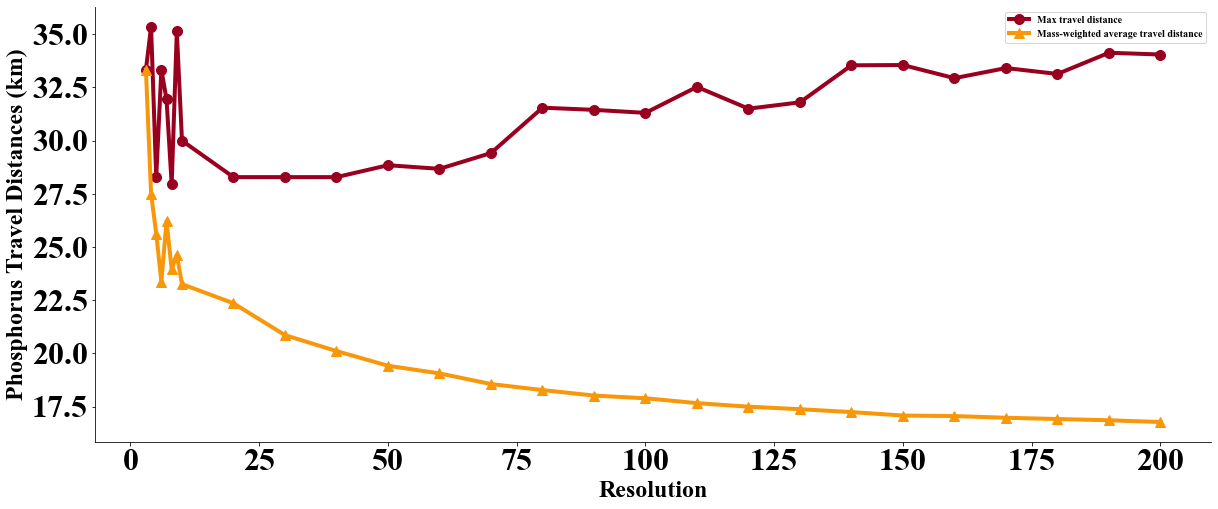

In [31]:
drawResoulutionTrends(df)

Text(0, 0.5, 'Total Transport Distance')

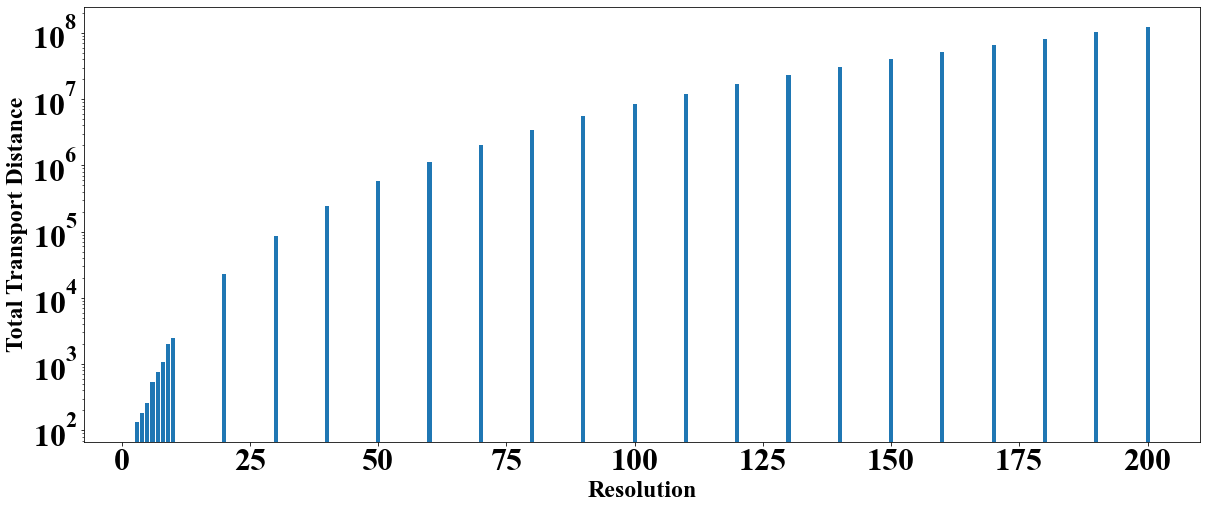

In [46]:
plt.figure(figsize=(20, 8))
plt.rc('font', family='Times New Roman', weight=600)
plt.bar(df['res'], df['TotalDistance'])
plt.yscale('log')
plt.yticks(fontsize=32)
plt.xlabel('Resolution', weight=600, fontsize=24)
plt.xticks(fontsize=32)
plt.ylabel('Total Transport Distance', weight=600, fontsize=24)